In [2]:
import numpy as np
import operator
import logging
import time

import optuna

import jax.numpy as jnp
from jax import grad, jit

from functools import partial
import gwjax
import gwjax.imrphenom

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter, sigmasq, get_cutoff_indices

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from optuna.visualization import plot_contour

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
class NeedsInvestigatingCallback(object):
    """A callback for Optuna which identifies potential events."""

    def __init__(self, early_stopping_rounds: int, snr_threshold: int, direction: str = "minimize") -> None:
        self.snr_threshold = snr_threshold
        self.early_stopping_rounds = early_stopping_rounds
        
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Goes onto Stocastic Gradient Descent."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._score <= self.snr_threshold:
            if self._iter >= self.early_stopping_rounds:
                study.stop()
                print(study.best_params)
                
        if self._score >= self.snr_threshold:
            study.stop()
            print(f'Optuna has stopped with {study.best_params} because snr threshold has been reached.')

In [43]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

# Define the matched filter function
def matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore, template): 
    workspace = jnp.zeros(int(sampling_rate*signal_duration), dtype=complex) 
    result_fft = fcore * jnp.conjugate(template) 
    workspace = workspace.at[kmin:kmax].set(result_fft)
    result = jnp.fft.ifft(workspace)
    result *= len(result)
    return result

# Define the waveform template function
def waveform_template(freqs, m1, m2, s1, s2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': s1, 'spin2': s2,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

# Define sigma squared function 
def sigma_squared(delta_freq, invpsd, template):
    weighted_inner = jnp.sum(template*jnp.conj(template)*invpsd)
    h_norm = 4*delta_freq
    sigma_squared = jnp.real(weighted_inner)*h_norm
    #print(f'sigma_squared {sigma_squared}')
    return sigma_squared

# Define the waveform template function
def optuna_waveform_template(freqs, m1, m2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': 0, 'spin2': 0,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

def snr(invpsd, delta_freq, sampling_rate, matched_output, sigma_squared_output):
    norm = 4*delta_freq / jnp.sqrt(sigma_squared_output)
    snr = matched_output*norm
    snr_min = int((2+4)*sampling_rate)
    snr_max = len(snr)-int((2)*sampling_rate)
    snr = snr[snr_min:snr_max]
    peak = jnp.argmax(jnp.absolute(snr))
    snrp = jnp.absolute(snr[peak])
    return(snrp)


# Define the objective function to minimize (negative SNR)
def objective(params):
    m1, m2, s1, s2 = params
    template, _ = my_waveform_template(m1, m2, s1, s2)
    
    
    for ifo in ifos:
        matched_output = matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore[ifo], template)
        #print(matched_output)
        sigma_squared_output = sigma_squared(delta_freq, invpsd[ifo], template)
        #print(sigma_squared_output)
        snr_peak = snr(invpsd[ifo], delta_freq, sampling_rate, matched_output, sigma_squared_output)
        print(snr_peak)
    #print(snr_peak)
    return -snr_peak

In [44]:
merger = Merger("GW150914") # Get the data 
ifos = ['H1', 'L1'] #Get detectors
sampling_rate = 2048 # Sampling rate in Hz
signal_duration = 28.0 #duration of the signal in seconds
delta_freq = (1/signal_duration) #the frquency bins
kmin, kmax = int(15*signal_duration), int(900*signal_duration) #Determine the low freq and high frequency cut off

# Get the data and estimate the PSDs
strain = {ifo: condition(merger.strain(ifo), sampling_rate) for ifo in ifos}

fcore = {}
invpsd = {}
for ifo in ifos:
    data = strain[ifo]
    invpsd[ifo] = estimate_psd(data, delta_freq)**(-1)
    fcore[ifo] = data.to_frequencyseries()*invpsd[ifo]
    invpsd[ifo] = jnp.asarray(invpsd[ifo][kmin:kmax])
    fcore[ifo] = jnp.asarray(fcore[ifo][kmin:kmax])
    
    
nyquist = sampling_rate//2 #Get the nyquist frequency range
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration #Determine the frequency range 
freqs = freqs[kmin:kmax]

#Get the stage ready for the template
my_waveform_template = partial(waveform_template, freqs)
my_optuna_waveform_template = partial(optuna_waveform_template, freqs)
my_matched_filter = partial(matched_filter, signal_duration, sampling_rate, kmin, kmax, fcore)
my_sigma_squared = partial(sigma_squared, delta_freq, invpsd)
my_snr = partial(snr, invpsd, delta_freq, sampling_rate)

In [45]:
def optuna_objective(trial):
    m1 = trial.suggest_float('m1', 2, 100, step=0.001)
    m2 = trial.suggest_float('m2', 2, 100, step=0.001)
    s1 = trial.suggest_float('s1', -0.99, 0.99, step=0.001)
    s2 = trial.suggest_float('s2', -0.99, 0.99, step=0.001)
    template, _ = my_waveform_template(m1, m2, s1, s2)
    matched_output = my_matched_filter(template)
    sigma_squared_output = my_sigma_squared(template)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    return snr_peak

In [46]:
optuna.logging.disable_default_handler()
direction="maximize"
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction=direction)
needs_to_be_investigated = NeedsInvestigatingCallback(600, snr_threshold=200, direction=direction)
start_time = time.time()
study.optimize(optuna_objective, callbacks=[needs_to_be_investigated], n_trials=1000)
print("Time taken", time.time() - start_time)
print(f'GW150419 has the best {study.best_params} with a snr {study.best_value}')

Trial 0 failed with parameters: {'m1': 56.983000000000004, 'm2': 65.814, 's1': -0.659, 's2': 0.397} because of the following error: TypeError("unsupported operand type(s) for *: 'dict' and 'ArrayImpl'").
Traceback (most recent call last):
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_10337/3516736793.py", line 7, in optuna_objective
    matched_output = my_matched_filter(template)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_10337/2867166863.py", line 18, in matched_filter
    result_fft = fcore * jnp.conjugate(template)
                ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py", line 253, in deferring_binary_op
    raise TypeError(f"unsupported operand type(s) for {o

TypeError: unsupported operand type(s) for *: 'dict' and 'ArrayImpl'

/tmp/ipykernel_23873/2279335185.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


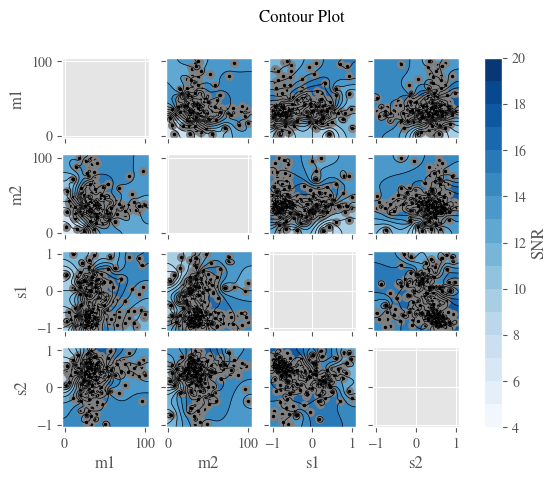

In [19]:
fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
#fig.set_title("")
#fig.set_xlabel("Mass 1")
#fig.set_ylabel("Mass 2")
#fig.figure.savefig('gwtuna_contour_plot2.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = optuna.visualization.matplotlib.plot_edf(study)

In [ ]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")
fig.set_title("")